In [1]:
from src.models.vae import VAE
from src.trainer import CLEARVAETrainer
from src.utils.display_utils import interpolate_latent
import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np

from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

from corruption_utils import corruptions
from expr.expr_utils import generate_style_dict, KStyledMNISTGenerator, KStyledMNIST

%load_ext autoreload
%autoreload 2

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [3]:
%%capture
mnist = torchvision.datasets.MNIST("../data", train=True, download=True)
# mnist = torchvision.datasets.FashionMNIST("../data", train=True, download=True)

In [4]:
from src.utils.data_utils import StyledMNISTGenerator, StyledMNIST

In [5]:
def display_util(idx1, idx2, z: torch.Tensor, model: VAE, z_dim):
    with torch.no_grad():
        z1, z2 = z[idx1], z[idx2]
        display(transforms.ToPILImage()(model.decode(z1.view(1, -1))[0]))
        display(transforms.ToPILImage()(model.decode(z2.view(1, -1))[0]))
        z_inter = interpolate_latent(latent1=z1[z_dim:], latent2=z2[z_dim:], num_steps=11)
        z_combined = torch.cat([z1[:z_dim][None, :].repeat(11, 1), z_inter], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate style:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()

        z_inter = interpolate_latent(latent1=z1[:z_dim], latent2=z2[:z_dim], num_steps=11)
        z_combined = torch.cat([z_inter, z1[z_dim:][None, :].repeat(11, 1)], dim=1)
        x_inter = model.decode(z_combined)
        print("interpolate content:")
        plt.imshow(make_grid(x_inter, nrow=11).permute(1, 2, 0).cpu())
        plt.axis('off')
        plt.show()


### in distribution

In [6]:
np.random.seed(101)
torch.manual_seed(101)

In [7]:
generator = StyledMNISTGenerator(
    mnist,
    {
        corruptions.identity: 0.1,
        corruptions.stripe: 0.15,
        corruptions.zigzag: 0.25,
        corruptions.canny_edges: 0.15,
        lambda x: corruptions.scale(x, 5): 0.15,
        corruptions.brightness: 0.2
    },
)


In [8]:
dataset = StyledMNIST(
    generator, transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0])
)

train, test, valid = random_split(dataset, [40000, 10000, 10000])


Generating dataset: 100%|██████████| 60000/60000 [00:15<00:00, 3850.71item/s]


### out-of-distribution

In [5]:
style_fns = [
    corruptions.identity,
    corruptions.stripe,
    corruptions.zigzag,
    corruptions.canny_edges,
    lambda x: corruptions.scale(x, 5),
    corruptions.brightness,
]
K = 3

In [ ]:
np.random.seed(101)
torch.manual_seed(101)
mnist = torchvision.datasets.MNIST("../data", train=True)
mnist_train, mnist_test = random_split(mnist, [50000, 10000])
style_dict = generate_style_dict(
    classes=list(range(10)), styles=list(range(len(style_fns))), k=K
)
mnist_generator = KStyledMNISTGenerator(mnist_train, style_fns, style_dict, "train")
train = KStyledMNIST(
    mnist_generator,
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
)
mnist_generator = KStyledMNISTGenerator(mnist_test, style_fns, style_dict, "test")
test = KStyledMNIST(
    mnist_generator,
    transforms.Compose([transforms.ToTensor(), lambda img: img / 255.0]),
)
train, valid = random_split(train, [0.85, 0.15])

In [ ]:
style_dict

### Experiment

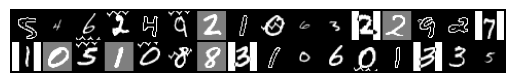

In [9]:
test_loader = DataLoader(test, batch_size=32, shuffle=False)

X, label, style = next(iter(test_loader))
X = X.to(device)
label = label.to(device)

plt.imshow(
    make_grid(X.cpu(), nrow=16).permute(1, 2, 0)
)
plt.axis('off')
plt.show()


Hamaguchi, et al. (2019) state that the distance/similarity metric between two Gaussians is recommended to take both the $\mu$ and the $\Sigma$ into account. However, these unexpectedly lead to blurring in reconstruction and in turn result in lower gMIG. Therefore, we use `cosine` and `l2` in the constrastive loss.

### cosine sim + label-flipping

In [29]:
Z_DIM = 16
TEMP = 0.3
ALPHA = 1e2
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="cosine",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [ ]:
trainer.fit(31, dataloader, val_dataloader)

In [28]:
trainer.evaluate(test_loader, False, 0)

(0.2672092263343405, 20.362957000732422)

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


In [40]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', "scale", 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [43]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3, label=f"{i}")
    ax.legend(loc='upper left')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [86]:
test_loader = DataLoader(test, batch_size=128, shuffle=True)
X, c, s = next(iter(test_loader))
X = X.to(device)
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)


### l2 sim + lable-flipping

In [22]:
Z_DIM = 16
TEMP = 0.3
ALPHA = 1e2
LABEL_FLIPPING = True

vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=5e-4)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="l2",
    hyperparameter={"temperature": TEMP, "beta": 1/8, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=5,
    device=device,
)

In [23]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 220.39it/s]


val_recontr_loss=65.636, val_kl_c=10.480, val_kl_s=11.052, val_c_loss=0.345, val_s_loss=0.117
gMIG: 0.197; elbo: 65.636


val-epoch 5: 100%|██████████| 79/79 [00:00<00:00, 234.20it/s]


val_recontr_loss=34.058, val_kl_c=13.890, val_kl_s=16.252, val_c_loss=0.183, val_s_loss=0.119
gMIG: 0.246; elbo: 34.058


val-epoch 10: 100%|██████████| 79/79 [00:00<00:00, 241.22it/s]


val_recontr_loss=27.536, val_kl_c=14.289, val_kl_s=17.781, val_c_loss=0.153, val_s_loss=0.115
gMIG: 0.253; elbo: 27.536


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 215.65it/s]


val_recontr_loss=23.946, val_kl_c=15.254, val_kl_s=18.867, val_c_loss=0.158, val_s_loss=0.114
gMIG: 0.268; elbo: 23.946


val-epoch 20: 100%|██████████| 79/79 [00:00<00:00, 234.06it/s]


val_recontr_loss=21.899, val_kl_c=15.610, val_kl_s=19.109, val_c_loss=0.155, val_s_loss=0.114
gMIG: 0.277; elbo: 21.899


val-epoch 25: 100%|██████████| 79/79 [00:00<00:00, 247.74it/s]


val_recontr_loss=21.611, val_kl_c=15.946, val_kl_s=19.652, val_c_loss=0.168, val_s_loss=0.113
gMIG: 0.271; elbo: 21.611


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 206.72it/s]


val_recontr_loss=20.394, val_kl_c=15.787, val_kl_s=20.203, val_c_loss=0.145, val_s_loss=0.113
gMIG: 0.28; elbo: 20.394


In [24]:
trainer.evaluate(test_loader, False, 0)

(0.28113462745656487, 20.10638427734375)

In [168]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)


In [169]:
vae.eval()
X_hat, latent_params, z = vae(X.clone(), explicit=True)

In [ ]:
display_util(9, 26, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(17, 30, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 31, z, vae, int(Z_DIM / 2))

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)


In [32]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [35]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]
fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 100))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 9
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [53, 88, 62, 67, 73, 85, 71, 79, 98, 68]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))

### mahalanobis / modified l2 + label flipping

In [25]:
Z_DIM = 16
TEMP = 2
ALPHA = 10
LABEL_FLIPPING = True

In [29]:
vae = VAE(total_z_dim=Z_DIM).to(device)
dataloader = DataLoader(train, batch_size=128, shuffle=True)
val_dataloader = DataLoader(valid, batch_size=128, shuffle=False)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
trainer = CLEARVAETrainer(
    vae,
    optimizer,
    sim_fn="jeffrey",
    hyperparameter={"temperature": TEMP, "beta": 1/2, "loc": 0, "scale": 1,
                    "alpha": ALPHA, "label_flipping": LABEL_FLIPPING},
    verbose_period=3,
    device=device,
)

In [30]:
trainer.fit(31, dataloader, val_dataloader)

val-epoch 0: 100%|██████████| 79/79 [00:00<00:00, 214.88it/s]


val_recontr_loss=53.657, val_kl_c=6.368, val_kl_s=6.296, val_c_loss=0.300, val_s_loss=0.140
gMIG: 0.149; elbo: 53.657


val-epoch 3: 100%|██████████| 79/79 [00:00<00:00, 219.15it/s]


val_recontr_loss=32.443, val_kl_c=7.500, val_kl_s=5.970, val_c_loss=0.208, val_s_loss=0.146
gMIG: 0.163; elbo: 32.443


val-epoch 6: 100%|██████████| 79/79 [00:00<00:00, 221.57it/s]


val_recontr_loss=28.012, val_kl_c=7.647, val_kl_s=6.611, val_c_loss=0.189, val_s_loss=0.159
gMIG: 0.167; elbo: 28.012


val-epoch 9: 100%|██████████| 79/79 [00:00<00:00, 223.05it/s]


val_recontr_loss=25.541, val_kl_c=7.927, val_kl_s=7.367, val_c_loss=0.211, val_s_loss=0.201
gMIG: 0.165; elbo: 25.541


val-epoch 12: 100%|██████████| 79/79 [00:00<00:00, 204.62it/s]


val_recontr_loss=24.652, val_kl_c=8.199, val_kl_s=6.758, val_c_loss=0.195, val_s_loss=0.163
gMIG: 0.172; elbo: 24.652


val-epoch 15: 100%|██████████| 79/79 [00:00<00:00, 225.56it/s]


val_recontr_loss=23.468, val_kl_c=8.251, val_kl_s=7.105, val_c_loss=0.231, val_s_loss=0.184
gMIG: 0.165; elbo: 23.468


val-epoch 18: 100%|██████████| 79/79 [00:00<00:00, 215.58it/s]


val_recontr_loss=22.772, val_kl_c=8.906, val_kl_s=6.752, val_c_loss=0.231, val_s_loss=0.177
gMIG: 0.172; elbo: 22.772


val-epoch 21: 100%|██████████| 79/79 [00:00<00:00, 223.85it/s]


val_recontr_loss=22.599, val_kl_c=8.550, val_kl_s=7.182, val_c_loss=0.199, val_s_loss=0.180
gMIG: 0.174; elbo: 22.599


val-epoch 24: 100%|██████████| 79/79 [00:00<00:00, 212.98it/s]


val_recontr_loss=21.762, val_kl_c=8.789, val_kl_s=7.363, val_c_loss=0.217, val_s_loss=0.194
gMIG: 0.169; elbo: 21.762


val-epoch 27: 100%|██████████| 79/79 [00:00<00:00, 204.17it/s]


val_recontr_loss=22.102, val_kl_c=8.507, val_kl_s=6.957, val_c_loss=0.216, val_s_loss=0.177
gMIG: 0.17; elbo: 22.102


val-epoch 30: 100%|██████████| 79/79 [00:00<00:00, 218.37it/s]


val_recontr_loss=21.136, val_kl_c=9.317, val_kl_s=7.272, val_c_loss=0.278, val_s_loss=0.183
gMIG: 0.173; elbo: 21.136


In [31]:
trainer.evaluate(test_loader, False, 0)

(0.17478951003898147, 20.933490753173828)

In [101]:
X, label, _ = next(iter(test_loader))
X = X.to(device)
label = label.to(device)
vae.eval()
X_hat, latent_params, z = vae(X, explicit=True)

In [ ]:
display_util(9, 16, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(1, 3, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(17, 14, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(14, 6, z, vae, int(Z_DIM / 2))

In [ ]:
display_util(31, 1, z, vae, int(Z_DIM / 2))

In [ ]:
from tqdm import tqdm

mu_cs = []
mu_ss = []
labels = []
styles = []
with torch.no_grad():
    for X, label, style in tqdm(val_dataloader):
        X = X.to(device)
        label = label.to(device)

        _, latent_params = vae(X)
        mu_cs.append(latent_params['mu_c'])
        mu_ss.append(latent_params['mu_s'])
        labels.append(label)
        styles.append(style)

mu_cs = torch.cat(mu_cs, dim=0)
mu_ss = torch.cat(mu_ss, dim=0)
labels = torch.cat(labels, dim=0)
styles = torch.cat(styles, dim=0)

In [88]:
from sklearn.manifold import TSNE

tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_cs_tsne = tsne.fit_transform(mu_cs.cpu().numpy())

In [ ]:
import matplotlib.pyplot as plt

plt.scatter(mu_cs_tsne[:, 0], mu_cs_tsne[:, 1], alpha=0.3, 
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale','brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_cs_tsne[i,0], mu_cs_tsne[i,1], alpha=0.2, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [91]:
tsne = TSNE(n_components=2, perplexity=30, learning_rate=200, init='pca')
mu_ss_tsne = tsne.fit_transform(mu_ss.cpu().numpy())

In [ ]:
plt.scatter(mu_ss_tsne[:,0], mu_ss_tsne[:,1], alpha=0.3,
            c=labels.cpu().numpy(), cmap='tab10')
plt.colorbar(label='Digit Class')

In [ ]:
fig, axs = plt.subplots(2, 5, figsize=(12, 5))
for i, ax in enumerate(axs.flat):
    cond = torch.where(labels == i)[0].cpu().numpy()
    ax.scatter(mu_ss_tsne[cond,0], mu_ss_tsne[cond,1], alpha=0.3)

In [ ]:
style_labels = ['identity', 'stripe', 'zigzag', 'canny_edge', 'scale', 'brightness']

cmap = plt.get_cmap('viridis')
colors = [cmap(i) for i in np.linspace(0, 1, len(style_labels))]

fig, ax = plt.subplots()
for g in range(len(style_labels)):
    i = np.where(styles == g)[0]
    ax.scatter(mu_ss_tsne[i,0], mu_ss_tsne[i,1], alpha=0.3, 
               c=colors[g], label=style_labels[g])
ax.legend()
plt.show()

In [ ]:
idxs = list(range(50, 150))

plt.scatter(mu_ss_tsne[:1000, 0], mu_ss_tsne[:1000, 1], alpha=0.3)
plt.scatter(mu_ss_tsne[idxs, 0], mu_ss_tsne[idxs, 1], c=labels[idxs].cpu().numpy(), cmap="tab10")
for i in idxs:
    plt.text(mu_ss_tsne[i, 0], mu_ss_tsne[i, 1], f"idx:{i}", fontsize=10)
plt.colorbar()

In [ ]:
idx = 1
display(transforms.ToPILImage()(vae.decode(
    torch.cat([mu_cs[idx], mu_ss[idx]]).view(1, -1)
)[0]))

In [ ]:
for i in [136, 120, 84, 50, 52]:
    display(transforms.ToPILImage()(vae.decode(
        torch.cat([mu_cs[idx], mu_ss[i]]).view(1, -1)
    )[0]))